<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Importing libraries and connecting with the data source</strong>



</div>

In [80]:
import os
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

NEON_URI = os.environ.get("DB_URI_NEON")
NEON_PASSWORD = os.environ.get("DB_PASSWORD_NEON")
if not NEON_URI or not NEON_PASSWORD:
    raise "DB_URI_NEON and DB_PASSWORD_NEON environment variables must be set"

NEON_CONNECTION_URI = f"postgresql+psycopg2://FlatsDB_owner:{NEON_PASSWORD}@{NEON_URI}/FlatsDB?sslmode=require" if NEON_URI and NEON_PASSWORD else None

In [82]:
engine = create_engine(NEON_CONNECTION_URI)
Session = sessionmaker(bind=engine)

In [84]:
def get_all_offers() -> pd.DataFrame:
    Q_GET_OFFERS = """
    SELECT *
    FROM offers;
    """    
    with Session() as session:
        res = session.execute(text(Q_GET_OFFERS))
        df = pd.DataFrame(res.fetchall())
        df.index = df["id"]
        df.drop("id", axis=1, inplace=True)
        df = df.replace("-1", np.nan)
        return df

In [86]:
df = get_all_offers()

In [87]:
df.head()

,url_id,price,area,rooms,floor,floor_num,construction_status,ownership,build_year,balcony,...,lift,garage,market,offer_type,city,voivodeship,longitude,latitude,created_at,modified_at
id,,,,,,,,,,,,,,,,,,,,,
4,142277,259000,41.97,2,floor_1,4,ready_to_use,full_ownership,NaN,1,...,0,0,secondary,mieszkanie,Wałbrzych,dolnośląskie,16.2769176,50.8111573,2024-09-30T15:47:02+02:00,2024-10-30T16:01:25+01:00
5,120108,389000,63.36,3,floor_1,7,ready_to_use,limited_ownership,1986,0,...,1,0,secondary,mieszkanie,Bydgoszcz,kujawsko-pomorskie,18.12956,53.15144,2024-04-14T22:25:22+02:00,2024-10-30T09:19:33+01:00
6,142666,495000,48.2,3,floor_9,10,to_renovation,limited_ownership,1967,1,...,1,0,secondary,mieszkanie,Poznań,wielkopolskie,16.90731,52.37182,2024-09-30T11:11:21+02:00,2024-10-30T11:16:07+01:00
7,159406,552628,54.91,3,floor_5,8,NaN,full_ownership,2026,1,...,1,0,primary,mieszkanie,Poznań,wielkopolskie,16.94986311727,52.375071665509,2024-10-16T21:45:37+02:00,2024-11-02T11:30:36+01:00
8,80447,400000,35.6,1,floor_3,5,ready_to_use,full_ownership,2000,0,...,0,0,secondary,mieszkanie,Poznań,wielkopolskie,16.91104258728,52.389239443068,2024-10-04T12:29:06+02:00,2024-10-31T09:53:33+01:00


<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Need to convert the data types in the dataframe</strong>
</div>

In [89]:
print(df.shape)
print(df.dtypes.value_counts())

(157275, 21)
object    20
int64      1
Name: count, dtype: int64


<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;
">

<strong>🎯 We can separate columns into these groups:</strong>

<table style="
    width: 100%;
    border-collapse: collapse;
    margin-top: 15px;
    font-size: 16px;
">
    <thead>
        <tr style="background-color: #e2e6f0; text-align: left;">
            <th style="padding: 10px; border-bottom: 2px solid #ddd;">Continuous</th>
            <th style="padding: 10px; border-bottom: 2px solid #ddd;">Discrete</th>
            <th style="padding: 10px; border-bottom: 2px solid #ddd;">Categorical</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Price</td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Rooms</td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Construction_Status</td>
        </tr>
        <tr>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Area</td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Floor</td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Ownership</td>
        </tr>
        <tr>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Longitude</td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Floor_num</td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Balcony</td>
        </tr>
        <tr>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Latitude</td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Terrace</td>
        </tr>
        <tr>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Created_At</td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Lift</td>
        </tr>
        <tr>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Modified_At</td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Garage</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Market</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Offer_type</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">City</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td style="padding: 8px; border-bottom: 1px solid #ddd;">Voivodeship</td>
        </tr>
    </tbody>
</table>
</div>


In [91]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = (df.isna().sum())/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['count'] = df.count().values
    return summary_df

summary(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
url_id,int64,0,0.000000,157275,157275
price,object,12580,0.079987,31962,144695
area,object,82,0.000521,10780,157193
rooms,object,82,0.000521,11,157193
floor,object,3133,0.019921,14,154142
floor_num,object,10364,0.065897,58,146911
construction_status,object,26432,0.168062,3,130843
ownership,object,28037,0.178267,4,129238
build_year,object,35787,0.227544,307,121488
balcony,object,82,0.000521,2,157193


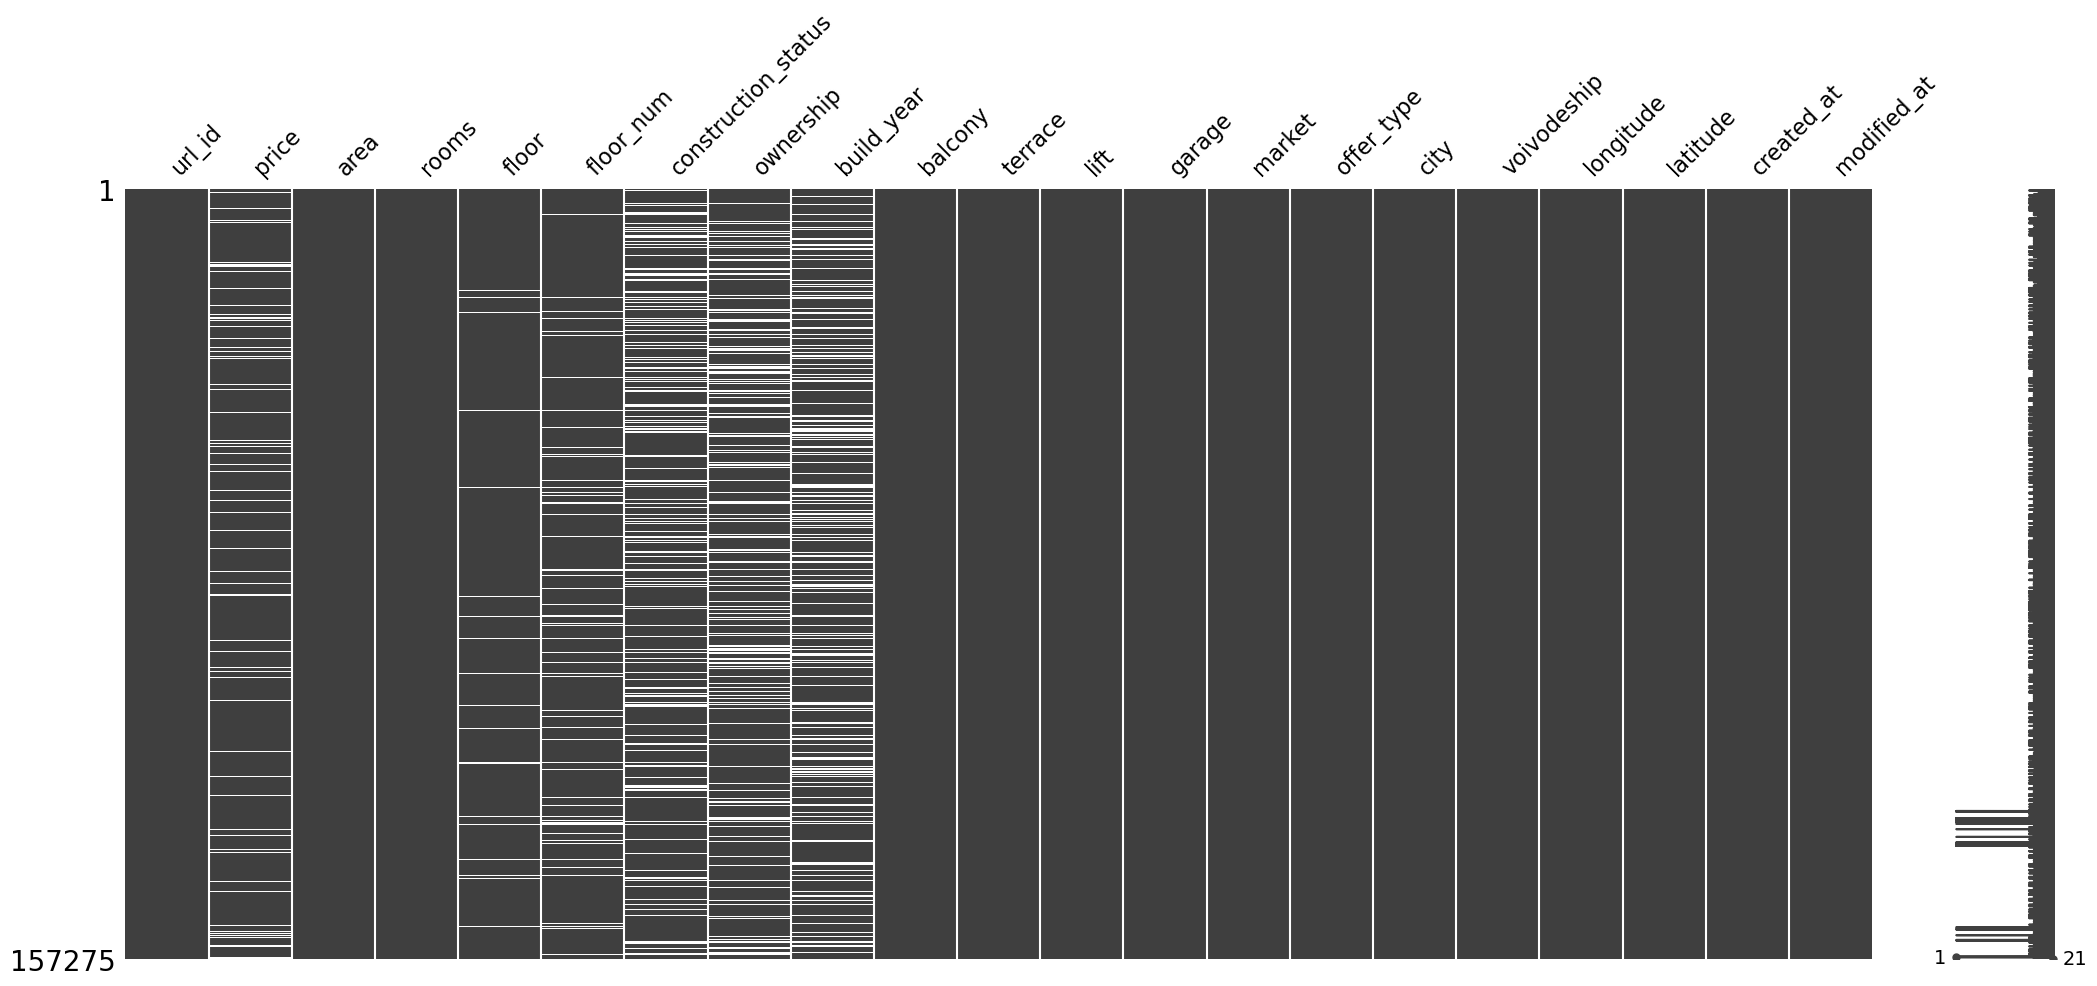

In [92]:
msno.matrix(df)
plt.show()

In [180]:
class EntryDataCleaning:
    """
    Entry pipeline, initially cleaning and preparing the data for the further processing.
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df.copy()

    def entry_filter(self):
        trash_rows = (self.df["price"].isna()) | (self.df["floor"].isna()) | \
                (self.df["floor_num"].isna() & self.df["construction_status"].isna() & self.df["ownership"].isna() & self.df["build_year"].isna())
        floor_filter = ~(self.df["floor"].isin(["cellar", "garret"]))
        self.df = self.df[(~trash_rows) & floor_filter]
        return self

    def extract_floors(self):
        self.df["floor"] = self.df["floor"].apply(lambda x: x.split("_")[-1] if "ground" not in x else "0")
        return self

    def extract_rooms(self):
        self.df = self.df[self.df["rooms"].str.isdigit().astype(bool)]
        return self
    
    def fill_ownership(self): # if there is NaN I read it as full_ownership
        self.df.loc[self.df["ownership"].isna(), "ownership"] = "full_ownership"
        return self

    def fill_status(self): # if build_year >= 2024 -> it's to_completion mostly
        self.df.loc[(self.df["build_year"] >= "2024") & (self.df["construction_status"].isna()), "construction_status"] = "to_completion"
        return self
    
    def cast_datatypes(self):
        self.df["price"] = self.df["price"].astype(int)
        for col in ["created_at", "modified_at"]:
            self.df[col] = pd.to_datetime(self.df[col], utc=True)
        for col in ["balcony", "terrace", "lift", "garage", "rooms", "floor"]:
            self.df[col] = self.df[col].astype(np.int8)
        for col in ["area", "latitude", "longitude"]:
            self.df[col] = self.df[col].astype(np.float64)
        for col in ["voivodeship", "city", "offer_type", "market", "ownership"]:
            self.df[col] = self.df[col].astype(str)
        return self

    def run(self) -> pd.DataFrame:
        return (
            self.entry_filter()
            .extract_floors()
            .extract_rooms()
            .fill_ownership()
            .fill_status()
            .cast_datatypes()
            .df )

In [182]:
entry_clean_pipeline = EntryDataCleaning(df)

In [184]:
df_t = entry_clean_pipeline.run()

In [186]:
df_t.dtypes

url_id                               int64
price                                int32
area                               float64
rooms                                 int8
floor                                 int8
floor_num                           object
construction_status                 object
ownership                           object
build_year                          object
balcony                               int8
terrace                               int8
lift                                  int8
garage                                int8
market                              object
offer_type                          object
city                                object
voivodeship                         object
longitude                          float64
latitude                           float64
created_at             datetime64[ns, UTC]
modified_at            datetime64[ns, UTC]
dtype: object

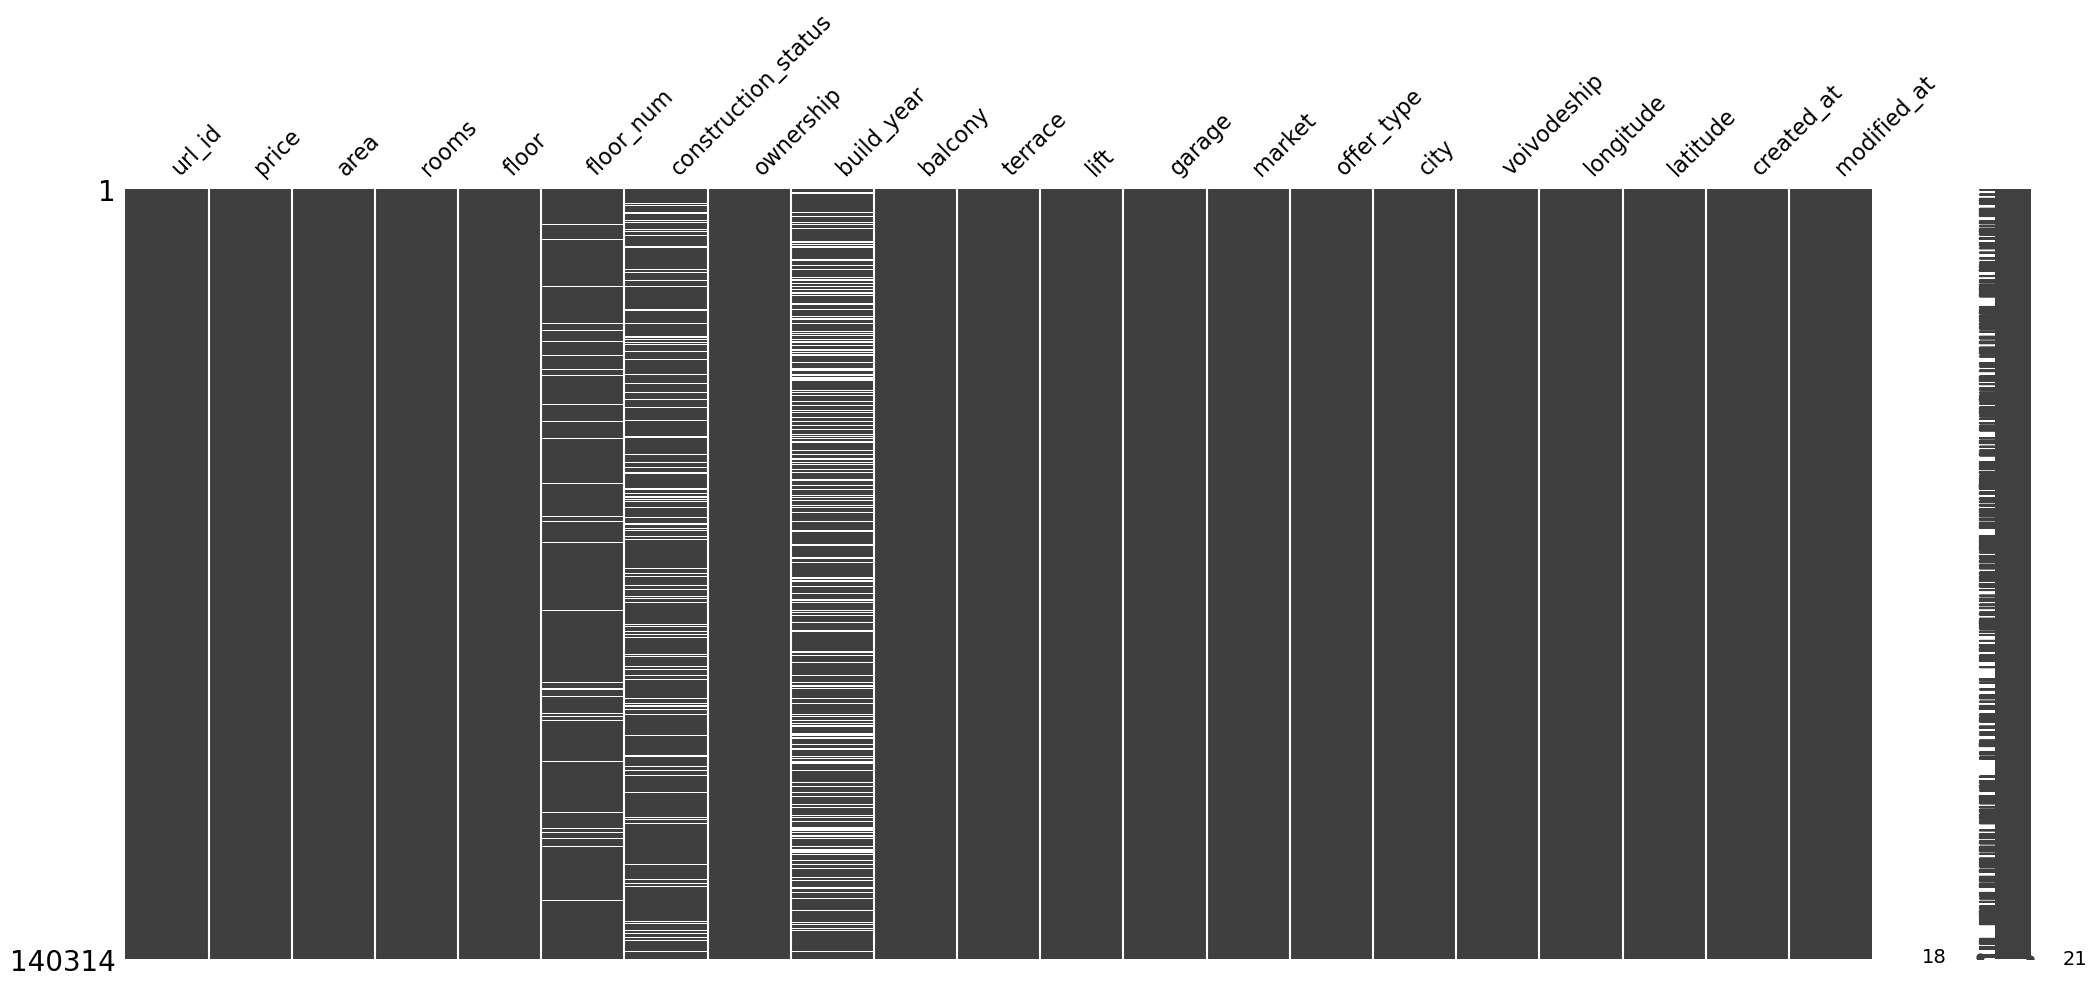

In [158]:
msno.matrix(df_t)
plt.show()